<a href="https://colab.research.google.com/github/Dcodinginsane/Data-Analysis-project/blob/main/netflix_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommender System Using Surprise Library

# **Introduction**


## **Why do we need recommender systems?**
All entertainment websites or online stores have millions/billions of items. It becomes challenging for the customer to select the right one.
At this place, recommender systems come into the picture and help the user to find the right item by minimizing the options.


## **What are recommender systems?**
It helps the user to select the right item by suggesting a presumable list of items and so it has become an integral part of e-commerce, movie and music rendering sites and the list goes on.
They are becoming one of the most popular applications of machine learning which has gained importance in recent years.
The two most popular ways it can be approached/built are:

1- Content-based recommendations (link).

2- Collaborative FIltering (link).


In this post, we will be focussing on the Collaborative filtering method that is: *the user is recommended items that people with similar tastes and preferences liked in the past.*


We will be working with MoiveLens Dataset, a movie rating dataset, to develop a recommendation system using the surprise library. Let's get started!



# Loading Required Libraries

In [ ]:
#!pip install surprise
import os
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import SVD
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict


from collections import deque
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# **THE DATA**

In [ ]:
# Loading the data and getting into form
# Load data for all movies
movie_titles = pd.read_csv('../input/netflix-prize-data/movie_titles.csv',
                           encoding = 'ISO-8859-1',
                           header = None,
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(17770, 2)


Year                                            Name
Id                                                           
8618   2001.0  Jay and Silent Bob Strike Back: Bonus Material
7181   1999.0                                   Sexual Matrix
12141  1988.0                                     Casual Sex?
4854   1975.0                          In This House of Brede
6611   2000.0                                         Ed Gein

In [ ]:
# Load a movie metadata dataset
movie_metadata = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv', low_memory=False)[['original_title', 'overview', 'vote_count']].set_index('original_title').dropna()
# Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


overview
original_title                                                                
Three Men and a Little Lady  Sylvia's work increasingly takes her away from...
にっぽん昆虫記                      A woman, Tome, is born to a lower class family...
あずみ                          In war-torn Japan, the Tokugawa Shogun, desper...
Out in the Dark              Two young men — a Palestinian grad student and...
Бармен                       Vadim is an ordinary office worker with no pro...

In [ ]:
#messy mixture of json and csv.

# Load single data-file
df_raw = pd.read_csv('../input/netflix-prize-data/combined_data_1.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])


# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):

    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()

    # Create movie_id column
    tmp_df['Movie'] = movie_id

    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
rating = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(rating.shape))
rating.sample(5)

Shape User-Ratings:	(24053764, 4)


User  Rating        Date  Movie
11602451  1275931     3.0  2004-07-16   2200
5882748   1583023     3.0  2005-04-29   1148
1225307    178767     2.0  2005-04-02    273
20688962   658202     4.0  2005-07-02   3917
11122604  1513267     4.0  2005-12-27   2152

In [ ]:
rating.shape

(24053764, 4)

In [ ]:
rating = rating[0:300000]

In [ ]:
ratings = rating[['User','Movie','Rating']]

In [ ]:
ratings.columns = ['userId','movieId','rating']

In [ ]:
ratings

userId  movieId  rating
1       1488844        1     3.0
2        822109        1     5.0
3        885013        1     4.0
4         30878        1     4.0
5        823519        1     3.0
...         ...      ...     ...
300072  1298406       77     3.0
300073   972399       77     2.0
300074  2224485       77     1.0
300075  1556164       77     5.0
300076  1386737       77     4.0

[300000 rows x 3 columns]

In [ ]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.shape

(300000, 3)

To load a data set from the above pandas data frame, we will use the **load_from_df()** method, we will also need a **Reader object**, and the **rating_scale** parameter must be specified.

The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order.

In [ ]:
# Define the format
reader = Reader(line_format='user item rating timestamp', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split data into 5 folds

#data.split(n_folds=5)

In [ ]:
data

In [ ]:
ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

userId  rating
127914   305344      75
134221   387418      74
108920  2439493      73
50296   1664010      68
84704   2118461      58
34938   1461435      42
80010   2056022      41
70654   1932594      39
48541   1639792      36
23896   1314869      36

The minimumn number of ratings given by a user is 20, where as the most productive user is user-414 giving 2698 rating.
The data is properly distributed and the big chunk of ratings is between 3 and 5 which means people are not very hard towards rating

# Surprise - Model Selection


Surprise is a Python scikit building and analyzing recommender systems that deal with explicit rating data.
Maintained by **Nicolas Hug.**

http://surpriselib.com/

Some understanding on the algorithms before we start applying.

**1: Normal Predictor:** It predicts a random rating based on the distribution of the training set, which is assumed to be normal.
It's a basic algorithm that does not do much work but that is still useful for comparing accuracies.

**2: SVD:** It got popularized by Simon Funk during the Netflix prize and is a Matrix Factorized algorithm. If baselines are not used, it is equivalent to PMF.

**3: NMF:** It is based on Non-negative matrix factorization and is similar to SVD.

**4: KNN Basic:** This is a basic collaborative filtering algorithm method.


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(n_epochs = 1, n_factors = 20),]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)




In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

test_rmse  fit_time  test_time
Algorithm                                
SVD         1.013515  0.561419   0.977251

# Tunining algorithm parameters with <font color = red> GridSearchCV </font> to find the best parameters for the algorithm.

**Default values for svd( ):**

**n_factors**  - 100   
**n_epochs**  - 20   
**lr_all**  – 0.005   
**reg_all**   – 0.02

In [ ]:
#Run this for get the best hyperparameters
'''param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']'''

"param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],\n              'reg_all': [0.08, 0.1, 0.15]}\ngs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)\ngs.fit(data)\nalgo = gs.best_estimator['rmse']\nprint(gs.best_score['rmse'])\nprint(gs.best_params['rmse'])\n\n#Assigning values\nt = gs.best_params\nfactors = t['rmse']['n_factors']\nepochs = t['rmse']['n_epochs']\nlr_value = t['rmse']['lr_all']\nreg_value = t['rmse']['reg_all']"

In [ ]:
#Run for fast pass
param_grid = {'n_factors': [30], 'n_epochs': [35], 'lr_all': [0.001],
              'reg_all': [0.08]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

1.0017953776902044
{'n_factors': 30, 'n_epochs': 35, 'lr_all': 0.001, 'reg_all': 0.08}


# Training and Testing

We use the **train_test_split()** to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse.

We’ll then use the **fit()** method which will train the algorithm on the trainset, and the **test()** method which will return the predictions made from the testset

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.0022


1.0021788627479091

In [ ]:
predictions

[Prediction(uid='1928776', iid=44, r_ui=4.0, est=3.723072365355208, details={'was_impossible': False}),
 Prediction(uid='1655851', iid=58, r_ui=3.0, est=3.6354871621337814, details={'was_impossible': False}),
 Prediction(uid='454171', iid=16, r_ui=3.0, est=3.132442889042961, details={'was_impossible': False}),
 Prediction(uid='2556305', iid=71, r_ui=4.0, est=3.8229116068345856, details={'was_impossible': False}),
 Prediction(uid='1916555', iid=30, r_ui=4.0, est=3.8537815023067625, details={'was_impossible': False}),
 Prediction(uid='2025279', iid=30, r_ui=5.0, est=3.8349848921742478, details={'was_impossible': False}),
 Prediction(uid='1909667', iid=30, r_ui=4.0, est=3.808895707534261, details={'was_impossible': False}),
 Prediction(uid='1162101', iid=30, r_ui=5.0, est=3.808895707534261, details={'was_impossible': False}),
 Prediction(uid='2295554', iid=30, r_ui=5.0, est=3.808895707534261, details={'was_impossible': False}),
 Prediction(uid='1053673', iid=30, r_ui=3.0, est=3.8088957075

#### Let's check how good or bad our predictions are:
The following function will create a pandas data frame which will consist of these columns:

**UID:** user-id

**iid:** Movieid

**Rui:** the rating given by the user

**est:** rating estimated by the model

**Iu:** No of items rated by the user

**UI:** number of users that have rated this item

**err:** abs difference between predicted rating and the actual rating.


def get_Iu(uid):
    """
    args:
      uid: the id of the user
    returns:
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [ ]:
def get_Iu(uid): """ args: uid: the id of the user returns: the number of items rated by the user """
    try: return len(trainset.ur[trainset.to_inner_uid(uid)]) except ValueError: # user was not part of the trainset return 0

def get_Ui(iid): """ args: iid: the raw id of the item returns: the number of users that have rated the item. """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except
        ValueError: return 0

df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details']) df_predictions['Iu'] = df_predictions.uid.apply(get_Iu) df_predictions['Ui'] = df_predictions.iid.apply(get_Ui) df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

IndentationError: unexpected indent (<ipython-input-20-9a272c485900>, line 2)

In [ ]:
df_predictions.head()

NameError: name 'df_predictions' is not defined

### Let's see the 10 best and worst predictions our model made

In [ ]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

NameError: name 'df_predictions' is not defined

In [ ]:
best_predictions

NameError: name 'best_predictions' is not defined

In [ ]:
worst_predictions

NameError: name 'worst_predictions' is not defined

In [ ]:
ratings[0:10]

userId  movieId  rating
1   1488844        1     3.0
2    822109        1     5.0
3    885013        1     4.0
4     30878        1     4.0
5    823519        1     3.0
6    893988        1     3.0
7    124105        1     4.0
8   1248029        1     3.0
9   1842128        1     4.0
10  2238063        1     3.0

The worst predictions look pretty surprise. Let's look in more details of item "3996",  rated 0.5, our SVD algorithm predicts 4.4


In [ ]:
ratings.loc[ratings['movieId'] == 33]['rating'].describe()

count    6890.000000
mean        4.168650
std         1.152857
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
# To create plots
import matplotlib.pyplot as plt

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
%matplotlib inline

init_notebook_mode(connected=True)
temp = ratings.loc[ratings['movieId'] == 33]['rating']
configure_plotly_browser_state()

# Create trace
trace = go.Histogram(x = temp.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 5, size=.3))
 # Create layout
layout = go.Layout(title = 'Number of ratings Movie 1 has received',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# **K Recommendations**

## Recall and precision at K
Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.

## Conversion to binary
To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 3.5 as the threshold, which means any true rating above 3.5 will be considered relevant and below will be not relevant.

## Deciding 'k'
In recommendation systems, we are interested in showing the top N items to users and so the best is to compute precision and recall on top N values instead of calculating on all the items.


## Definition of Relevant and Recommended
**Relevant:** True Rating > = 2.5

**Irrelevant:** True Rating < 2.5
***
**Recommended item:** Predicted Rating > = 3.5

**Not Recommended item:** Predicted Rating > = 3.5

## Definition of Precision and Recall
**Precision:** It tries to answer "What proportion of positive identifications was actually correct?"
i.e True positive / (True positive+False Positive)
in RecSys we can say (# of recommended items @k that are relevant) / (# of recommended items @k)

**Recall:** It tries to answer "What proportion of actual positives were identified correctly?"
i.e True positive / (True Positive+False Negative)
in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)


**While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.**

In some circumstances, we might know that we need to maximize either **recall** or **precision** at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease.

However, in cases where we want to obtain an optimal blend of precision and recall, we can use **F1** score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

**f1 score = 2 * (precision * recall) / (precision + recall)**

The below function computes precision and recall and F1 socre as explained above.

In [ ]:

#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)

final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

threshold     tp     fp     tn     fn  Precision    Recall        F1
0         0.0  75000      0      0      0   1.000000  1.000000  1.000000
1         0.5  75000      0      0      0   1.000000  1.000000  1.000000
2         1.0  74995      0      0      5   1.000000  0.999933  0.999967
3         1.5  71470   3509     15      6   0.953200  0.999916  0.975999
4         2.0  71445   3471     53     31   0.953668  0.999566  0.976078
5         2.5  64326   9990    477    207   0.865574  0.996792  0.926561
6         3.0  60406   7548   2919   4127   0.888925  0.936048  0.911878
7         3.5  38617  20901  10551   4931   0.648829  0.886769  0.749364
8         4.0   2847    786  30666  40701   0.783650  0.065376  0.120684
9         4.5      9      1  58194  16796   0.900000  0.000536  0.001070
10        5.0      0      0  58195  16805   0.000000  0.000000  0.000000

As per the results above, the optimal value for threshold is **2.5**.

The next step is to find the optimal K value, and to find it we have to first calculate precision and recall for all the K values(2-10) having threshold value 2.5.

Below is the function to calculate **precision and recall @ K.**

In [ ]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls


###


In [ ]:

results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})


results

###


[{'K': 2, 'Precision': 0.8727506426735219, 'Recall': 0.9889929889338476},
 {'K': 3, 'Precision': 0.8718306601269057, 'Recall': 0.9960098638304514},
 {'K': 4, 'Precision': 0.8715875218824424, 'Recall': 0.9970969067346439},
 {'K': 5, 'Precision': 0.87155124828489, 'Recall': 0.9973458267637144},
 {'K': 6, 'Precision': 0.8715486197633282, 'Recall': 0.9974312903019512},
 {'K': 7, 'Precision': 0.8715422362109639, 'Recall': 0.9974514350793783},
 {'K': 8, 'Precision': 0.8715464606206169, 'Recall': 0.9974746777572175},
 {'K': 9, 'Precision': 0.8715464606206169, 'Recall': 0.9974826562348446},
 {'K': 10, 'Precision': 0.871546285385846, 'Recall': 0.9974886007374535}]

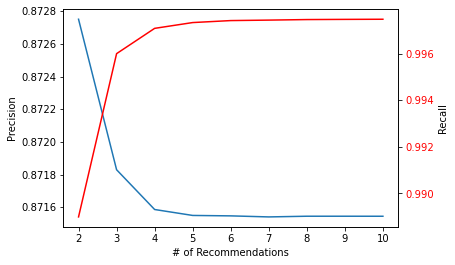

In [ ]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
    ###

As the graph states, Precision drops significantly when K=3

So we will consider the value of K to be 3.

# Time to recommend some movies to users

### Now as we know the optimal number of recommendations to provie, it's time to give recommendations to users. To do so we have to predict ratings for the movies which user has not yet watched.

Here we will be using **build_anti_testset()** method to get the data for testset as we have to predict ratings for the (user, item) pairs which are not present.

In [ ]:
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

Below is the function to get all the prediction sorted.

In [ ]:
def get_all_predictions(predictions):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n


In [ ]:

all_pred = get_all_predictions(predictions)


In [ ]:
all_pred

defaultdict(list,
            {'1488844': [(13, 4.39563800563764),
              (33, 4.203596718578081),
              (68, 4.1536059877534095),
              (37, 3.9853607506946593),
              (32, 3.9392466792056955),
              (25, 3.8982095082345607),
              (5, 3.85239404237369),
              (73, 3.787366373152709),
              (52, 3.774187070296535),
              (28, 3.7713452514024843),
              (71, 3.7713225162229245),
              (46, 3.752599159287536),
              (48, 3.703712553673321),
              (18, 3.702884015353966),
              (57, 3.633683955749299),
              (49, 3.624482782896569),
              (56, 3.6232632858135365),
              (29, 3.6147030453133255),
              (3, 3.602422254198698),
              (62, 3.575163894772031),
              (27, 3.5729960143157276),
              (51, 3.5495951447102954),
              (2, 3.545009442733318),
              (23, 3.518141118302819),
              (21, 3.506312919

#### As we have all the predicted rating, We'll subset to only top **K** movies for every user, where K is 4

In [ ]:
#To get top 4 reommendation
n = 3

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]


In [ ]:
all_pred

defaultdict(list,
            {'1488844': [(13, 4.39563800563764),
              (33, 4.203596718578081),
              (68, 4.1536059877534095)],
             '822109': [(13, 4.511522705072543),
              (33, 4.317816603019844),
              (68, 4.271382300182498)],
             '885013': [(13, 4.4894136345837135),
              (33, 4.265307340829703),
              (68, 4.2075882947883505)],
             '30878': [(13, 4.3579050142553974),
              (33, 4.169028342087909),
              (68, 4.103777955321559)],
             '823519': [(13, 4.459783696568728),
              (33, 4.248359493780843),
              (68, 4.1794543847256875)],
             '893988': [(13, 4.459712875650163),
              (33, 4.271419951653459),
              (68, 4.22693299506644)],
             '124105': [(13, 4.462975068130914),
              (33, 4.2812291626601695),
              (68, 4.219122382494978)],
             '1248029': [(13, 4.320600995089741),
              (33, 4.13188382034

### Voila, It's done!!